In [1]:
from google.colab import drive
import tensorflow as tf
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.regularizers import L1, L2

In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS109b Final Project

Mounted at /content/drive
/content/drive/MyDrive/CS109b Final Project


In [6]:
!unzip -o ./tf_data.zip;

Archive:  ./tf_data.zip
  inflating: tf_data/.DS_Store       
  inflating: __MACOSX/tf_data/._.DS_Store  
  inflating: tf_data/species_encoding.pkl  
  inflating: tf_data/test_data/.DS_Store  
  inflating: __MACOSX/tf_data/test_data/._.DS_Store  
  inflating: tf_data/test_data/snapshot.metadata  
  inflating: tf_data/test_data/dataset_spec.pb  
  inflating: tf_data/train_data/.DS_Store  
  inflating: __MACOSX/tf_data/train_data/._.DS_Store  
  inflating: tf_data/train_data/snapshot.metadata  
  inflating: tf_data/train_data/dataset_spec.pb  
  inflating: tf_data/validation_data/.DS_Store  
  inflating: __MACOSX/tf_data/validation_data/._.DS_Store  
  inflating: tf_data/validation_data/snapshot.metadata  
  inflating: tf_data/validation_data/dataset_spec.pb  
  inflating: tf_data/test_data/5032784652598476384/.DS_Store  
  inflating: __MACOSX/tf_data/test_data/5032784652598476384/._.DS_Store  
  inflating: tf_data/train_data/14527443316484762011/.DS_Store  
  inflating: __MACOSX/tf_data

In [7]:
!unzip -o ./tf_data_additional_4.zip;

Archive:  ./tf_data_additional_4.zip
  inflating: tf_data_additional/.DS_Store  
  inflating: __MACOSX/tf_data_additional/._.DS_Store  
  inflating: tf_data_additional/species_encoding.pkl  
  inflating: tf_data_additional/test_data/.DS_Store  
  inflating: __MACOSX/tf_data_additional/test_data/._.DS_Store  
  inflating: tf_data_additional/test_data/snapshot.metadata  
  inflating: tf_data_additional/test_data/dataset_spec.pb  
  inflating: tf_data_additional/train_data/.DS_Store  
  inflating: __MACOSX/tf_data_additional/train_data/._.DS_Store  
  inflating: tf_data_additional/train_data/snapshot.metadata  
  inflating: tf_data_additional/train_data/dataset_spec.pb  
  inflating: tf_data_additional/validation_data/snapshot.metadata  
  inflating: tf_data_additional/validation_data/dataset_spec.pb  
  inflating: tf_data_additional/test_data/12073845064448163246/00000000.shard/00000000.snapshot  
  inflating: tf_data_additional/train_data/7620346648989953827/00000000.shard/00000000.snap

In [3]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Available GPUs: 
[]



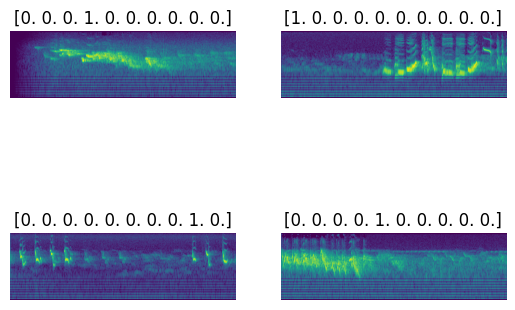

In [8]:
baseline_test_dataset = tf.data.Dataset.load('tf_data/test_data')
baseline_train_dataset = tf.data.Dataset.load('tf_data/train_data')
baseline_val_dataset = tf.data.Dataset.load('tf_data/validation_data')

fig, axs = plt.subplots(2,2)
for ax, img, label in [(a, *b) for a, b in zip(axs.ravel(), baseline_train_dataset.take(4))]:
    ax.imshow(img)
    ax.axis(False)
    ax.set_title(f'{label}')

In [9]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return normalize_image(img), label

baseline_train_dataset = baseline_train_dataset.map(preprocess)
baseline_val_dataset = baseline_val_dataset.map(preprocess)
baseline_test_dataset = baseline_test_dataset.map(preprocess)

In [10]:
additional_features_test_dataset = tf.data.Dataset.load('tf_data_additional/test_data')
additional_features_train_dataset = tf.data.Dataset.load('tf_data_additional/train_data')
additional_features_val_dataset = tf.data.Dataset.load('tf_data_additional/validation_data')

def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return {'image_input': normalize_image(img['image_input']), 'feature_input': img['feature_input']}, label

additional_features_train_dataset = additional_features_train_dataset.map(preprocess)
additional_features_val_dataset = additional_features_val_dataset.map(preprocess)
additional_features_test_dataset = additional_features_test_dataset.map(preprocess)

<_TakeDataset element_spec=({'image_input': TensorSpec(shape=(128, 431), dtype=tf.uint8, name=None), 'feature_input': TensorSpec(shape=(5,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float32, name=None))>


In [11]:
baseline_model = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(128, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 431, 80)      61520     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 431, 80)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 71, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 71, 160)       25760     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 71, 160)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 35, 160)       0         
 g2D)                                                   

In [12]:
baseline_model.load_weights('models/baseline.h5')

In [13]:
small_kernel_model = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(125, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

small_kernel_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 431, 80)      60080     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 431, 80)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 71, 80)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 71, 160)       25760     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 71, 160)       0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 35, 160)       0         
 g2D)                                                 

In [14]:
small_kernel_model.load_weights('models/smaller_kernel.h5')

In [15]:
input_img = tf.keras.Input((128, 431, 1), name='image_input')
first_conv = Conv2D(80, kernel_size=(125, 6), padding='same')(input_img)
first_rlu = LeakyReLU(alpha=0.3)(first_conv)
first_pool = MaxPooling2D(pool_size=(4, 6))(first_rlu)
second_conv = Conv2D(160, kernel_size=(1, 2), padding='same')(first_pool)
second_rlu = LeakyReLU(alpha=0.3)(second_conv)
second_pool = MaxPooling2D(pool_size=(1, 2))(second_rlu)
third_conv = Conv2D(240, kernel_size=(1, 2), padding='same')(second_pool)
third_rlu = LeakyReLU(alpha=0.3)(third_conv)
third_pool =  MaxPooling2D(pool_size=(1, 2))(third_rlu)
fourth_conv = Conv2D(320, kernel_size=(1, 2), padding='same')(third_pool)
fourth_rlu = LeakyReLU(alpha=0.3)(fourth_conv)
fourth_pool =  MaxPooling2D(pool_size=(1, 2))(fourth_rlu)
flatten = Flatten()(fourth_pool)
dropout = Dropout(0.5)(flatten)
input_features = tf.keras.Input(5, name='feature_input')
dense3 = Dense(100, activation='relu')(input_features)
dense6 = Dense(100, activation='relu')(dense3)
dropout3 = Dropout(0.5)(dense6)
dense4 = Dense(100, activation='relu')(dropout3)
dense5 = Dense(100, activation='relu')(dense4)
dropout4 = Dropout(0.5)(dense5)
concat = tf.keras.layers.Concatenate()([dropout, dropout4])
output= Dense(10, activation='softmax', kernel_regularizer=L2(0.001))(concat)






additional_features_model = Model(inputs =[input_img, input_features], outputs=output)

additional_features_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 128, 431, 1)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 431, 80)         60080     ['image_input[0][0]']         
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 431, 80)         0         ['conv2d_8[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 32, 71, 80)           0         ['leaky_re_lu_8[0][0]']       
 g2D)                                                                                         

In [16]:
additional_features_model.load_weights('models/other_features.h5')

In [19]:
def compute_saliency_map_baseline(model, image_tensor):
    with tf.GradientTape() as tape:
       tape.watch(image_tensor)
       predictions = model(image_tensor)

       # Consider the top predicted class or specify the class you want to visualize
       top_pred_index = tf.argmax(predictions[0])
       top_class_prediction = predictions[:, top_pred_index]

    # Get the gradients of the top predicted class with respect to the input image
    gradients = tape.gradient(top_class_prediction, image_tensor)

    # Get the sign of the gradients to create the saliency map
    saliency_map = tf.math.abs(gradients)
    saliency_map = tf.reduce_max(saliency_map, axis=-1) # Reduce across the channel dimension if necessary
    return saliency_map.numpy()

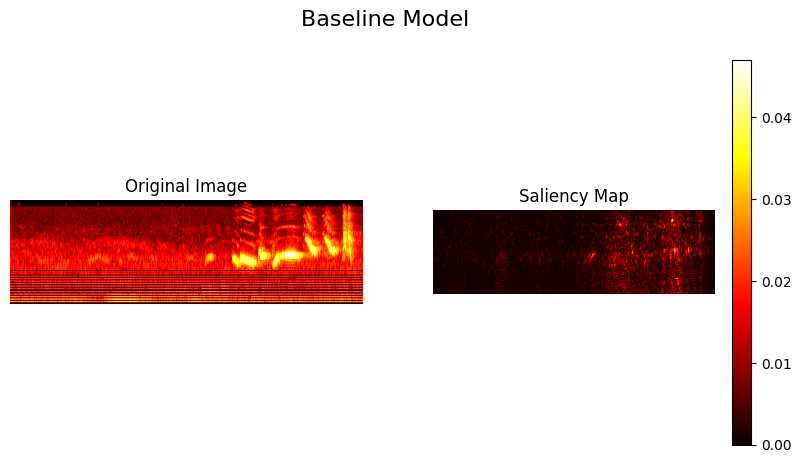

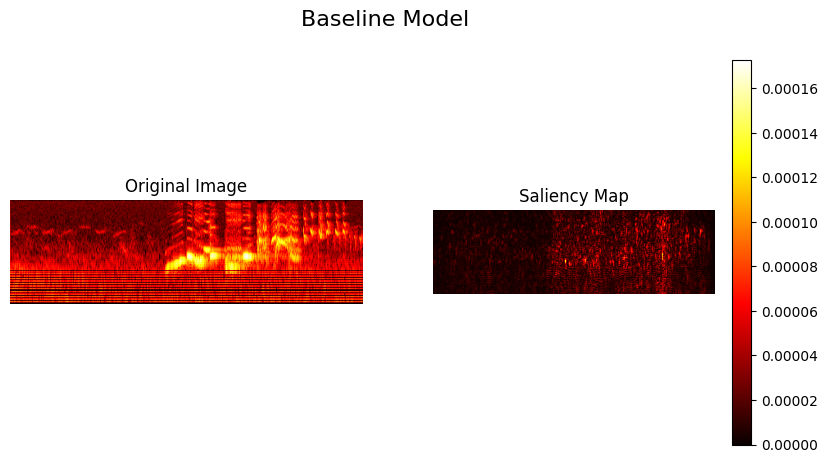

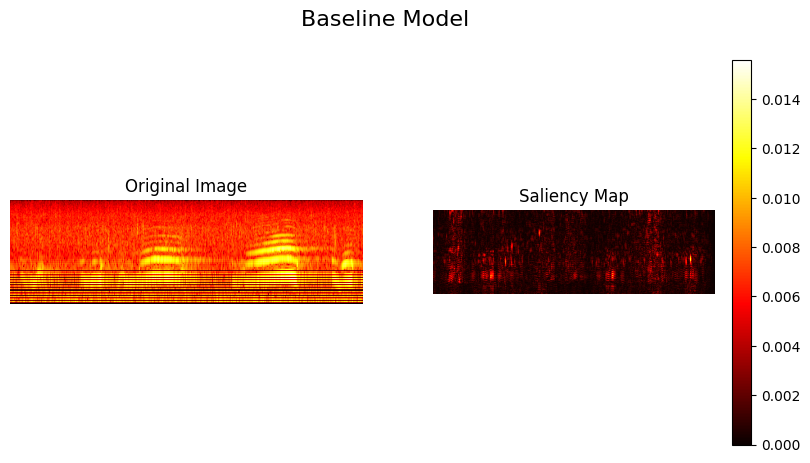

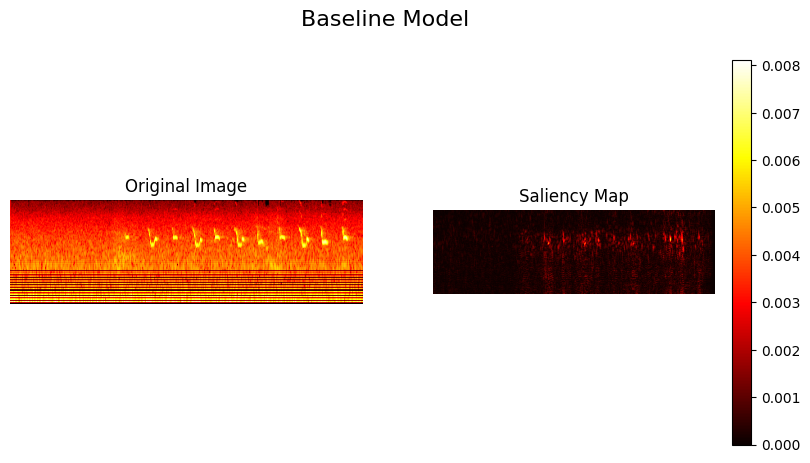

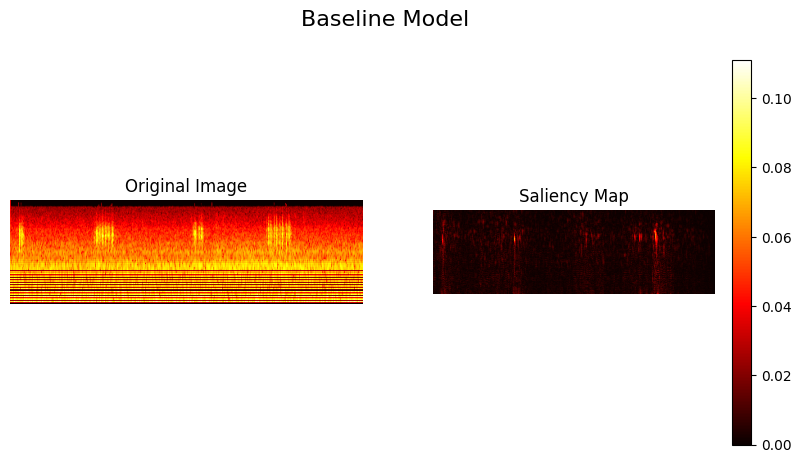

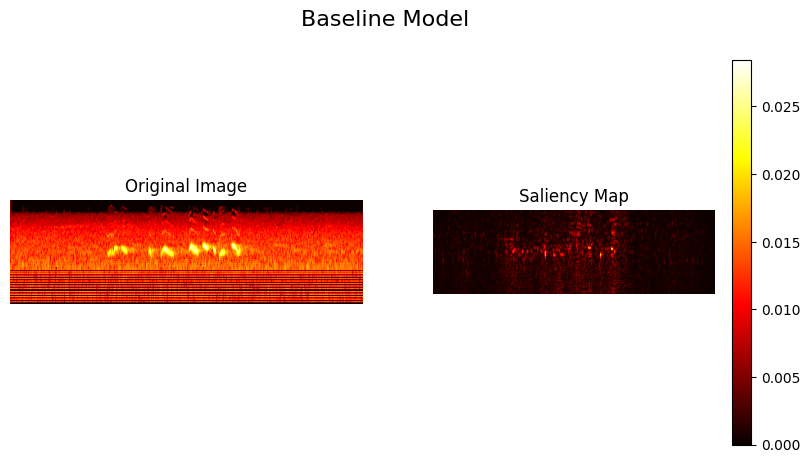

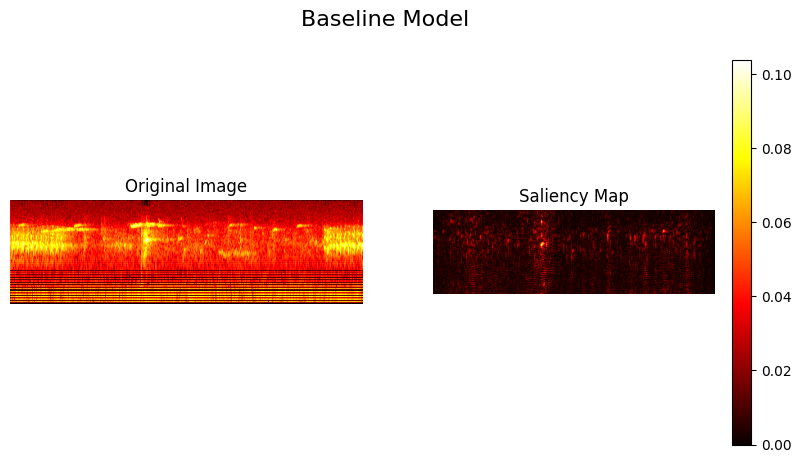

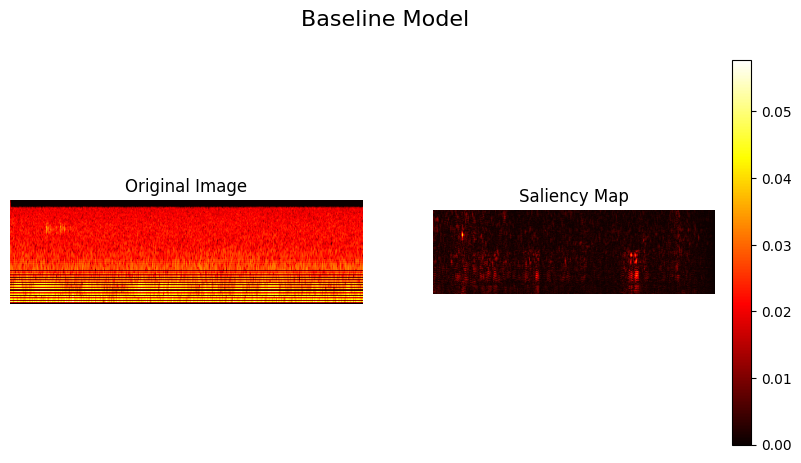

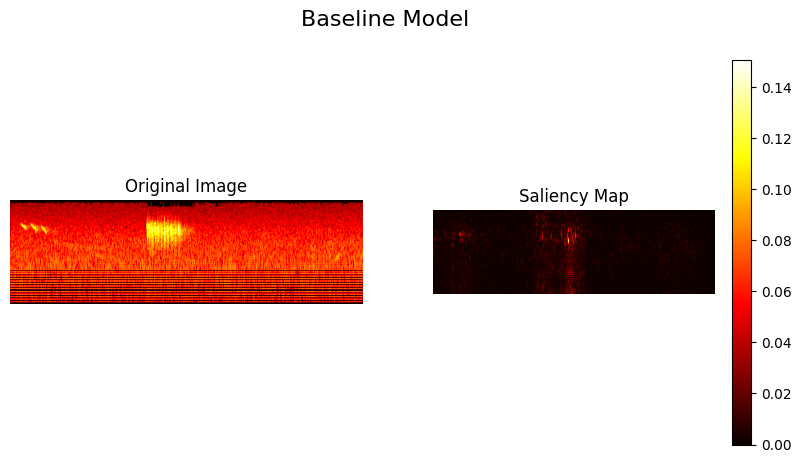

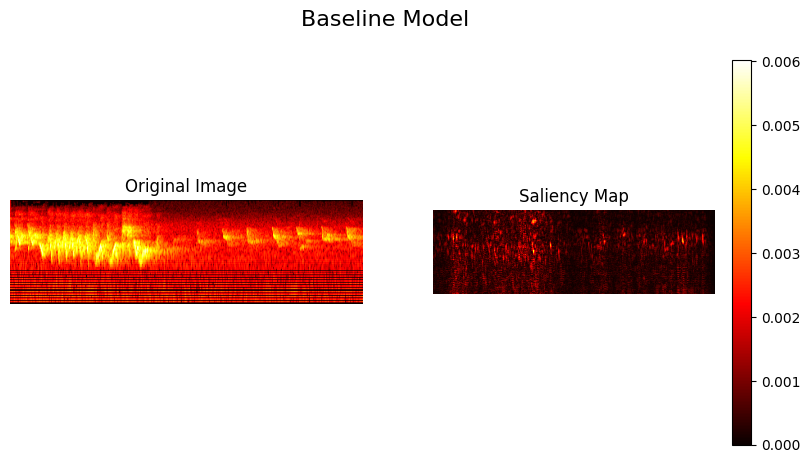

In [20]:
for image, label in baseline_test_dataset.take(10):
    original_image = image
    image = tf.expand_dims(image, axis=-1)
    image_with_batch_dimension = tf.expand_dims(image, axis=0)
    saliency_map = compute_saliency_map_baseline(baseline_model, image_with_batch_dimension)
    saliency_map = np.squeeze(saliency_map)

    # Create a figure to hold the subplots
    plt.figure(figsize=(10, 5))

    plt.suptitle("Baseline Model", fontsize=16)

    # Plot the original image
    plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
    plt.imshow(original_image, cmap='hot')
    plt.title("Original Image")
    plt.axis('off') # Hide the axis to make the image cleaner

    # Plot the saliency map
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
    plt.imshow(saliency_map, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off') # Hide the axis to make the image cleaner
    plt.colorbar() # Add a colorbar to interpret the saliency values

    # Display the plots
    plt.show()

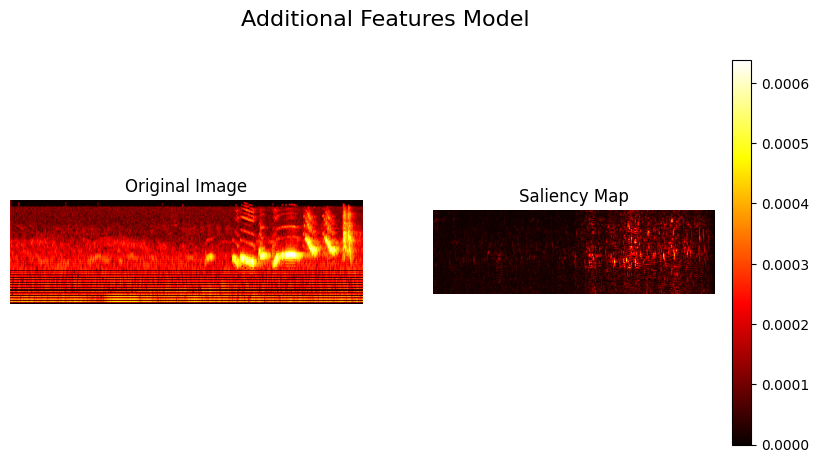

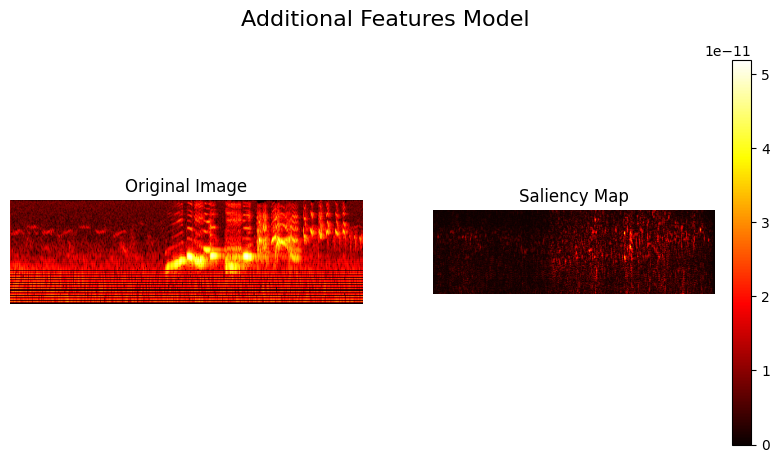

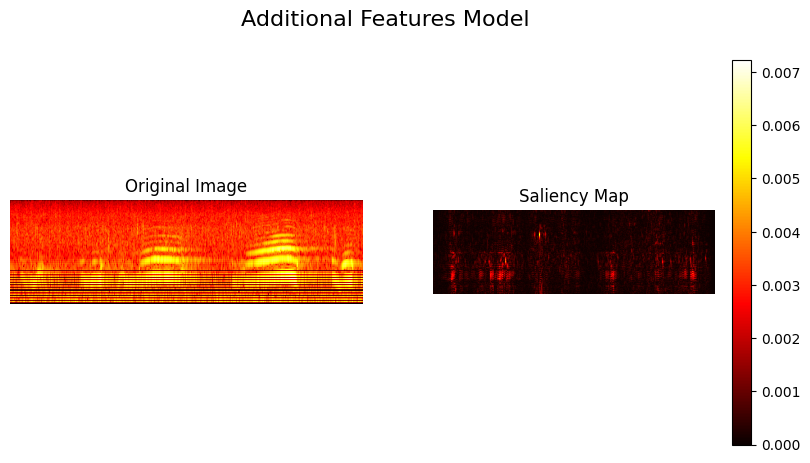

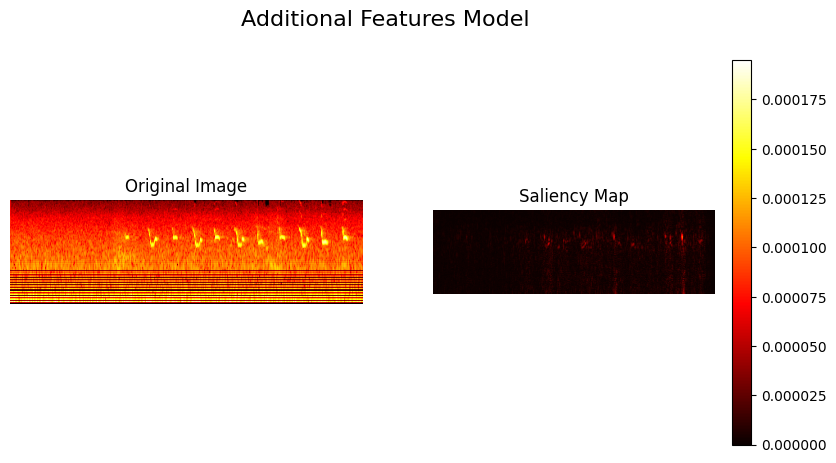

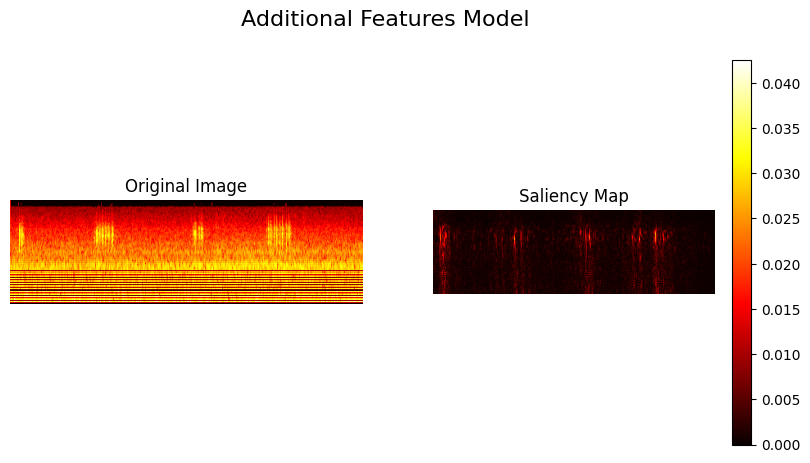

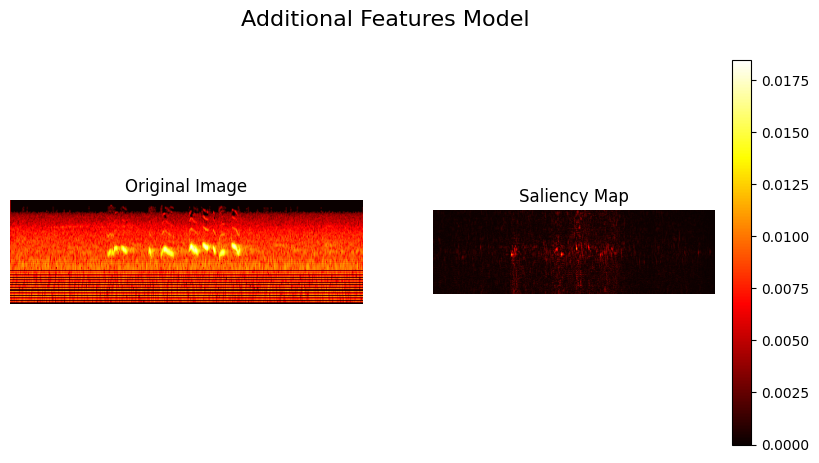

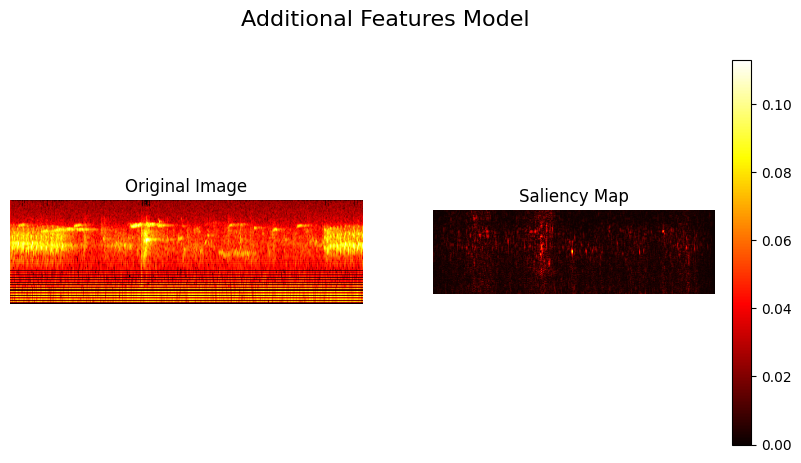

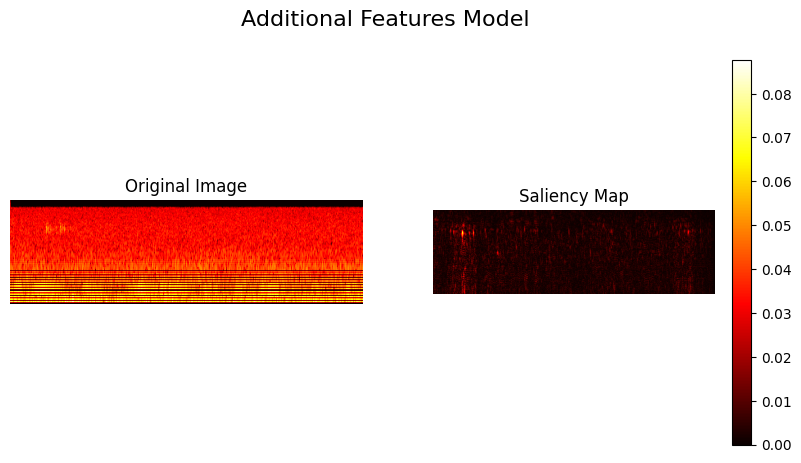

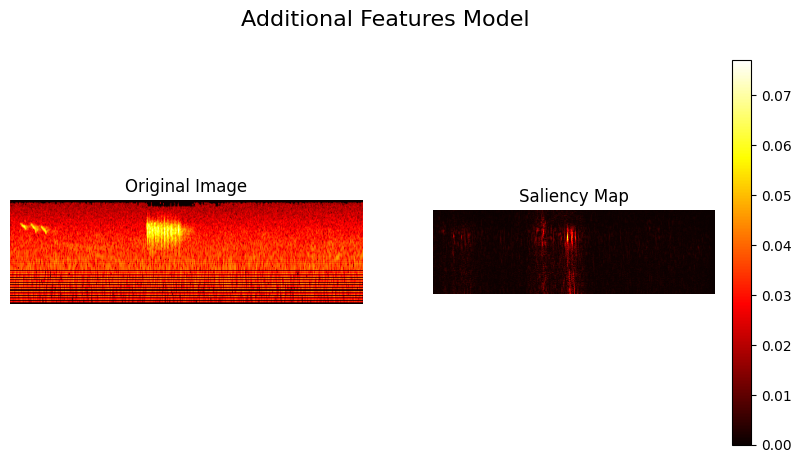

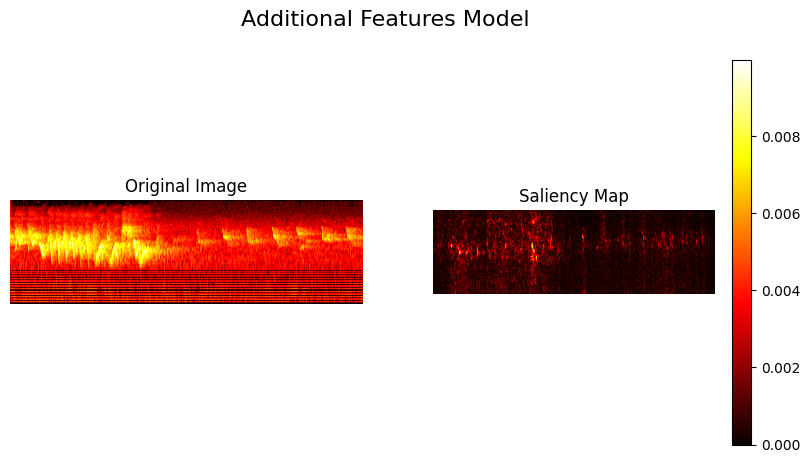

In [21]:
def compute_saliency_map_additional_features(model, image_tensor, feature_tensor):
    with tf.GradientTape() as tape:
       # Watch both tensors if you need gradients with respect to both
       tape.watch(image_tensor)
       tape.watch(feature_tensor)
       # Pass both inputs to the model as a list
       predictions = model([image_tensor, feature_tensor])

       # Consider the top predicted class or specify the class you want to visualize
       top_pred_index = tf.argmax(predictions[0])
       top_class_prediction = predictions[:, top_pred_index]

       # Get the gradients of the top predicted class with respect to the input image
       gradients = tape.gradient(top_class_prediction, image_tensor)

       # Get the sign of the gradients to create the saliency map
       saliency_map = tf.math.abs(gradients)
       saliency_map = tf.reduce_max(saliency_map, axis=-1) # Reduce across the channel dimension if necessary
       return saliency_map.numpy()

for input, label in additional_features_test_dataset.take(10):
    original_image = input['image_input']
    image = tf.expand_dims(input['image_input'], axis=-1)
    image_with_batch_dimension = tf.expand_dims(image, axis=0)
    feature_tensor = tf.expand_dims(input['feature_input'], axis=0)

    # Pass the feature tensor along with the image tensor to the compute_saliency_map function
    saliency_map = compute_saliency_map_additional_features(additional_features_model, image_with_batch_dimension, feature_tensor)
    saliency_map = np.squeeze(saliency_map)

    # Create a figure to hold the subplots
    plt.figure(figsize=(10, 5))

    plt.suptitle("Additional Features Model", fontsize=16)

    # Plot the original image
    plt.subplot(1, 2, 1) # 1 row, 2 columns, first subplot
    plt.imshow(np.squeeze(original_image), cmap='hot') # Ensure original image is squeezed
    plt.title("Original Image")
    plt.axis('off') # Hide the axis to make the image cleaner

    # Plot the saliency map
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second subplot
    plt.imshow(saliency_map, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off') # Hide the axis to make the image cleaner
    plt.colorbar() # Add a colorbar to interpret the saliency values

    # Display the plots
    plt.show()